In [2]:
%matplotlib inline

# Load CIFAR10 dataset

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

trainset, valset = torch.utils.data.random_split(trainvalset, [0.9, 0.1])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


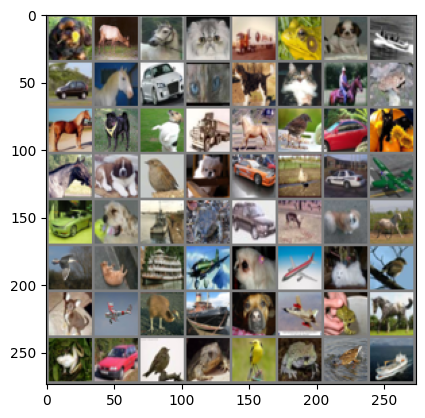

  dog  deer horse   cat


In [6]:
# function to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# VGG16 Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG16_BN_Weights
import copy
import gc

vgg = models.vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)

# Prevent weight update from backprop
for param in vgg.parameters():
    param.requires_grad = False

# Change the output layer to 10 classes
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)


torch.Size([10, 4096])
torch.Size([10])


## Train the model

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return correct / total

vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.001)

In [12]:
max_epochs = 20

n_iters = np.ceil(50000/batch_size)

min_loss = 1000

loss_epoch_arr = []
train_loss_arr = []
val_loss_arr = []
train_acc_arr = []
val_acc_arr = []

for epoch in range(max_epochs):
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()
        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        train_loss += loss.item()  # Accumulate training loss

        # Update minimum loss and save best model
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            # print('Min loss %0.2f' % min_loss)
        
        # Print training progress every 100 iterations
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, np.ceil(50000/batch_size), loss.item()))
            
        # Clear memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    
    # Record average training loss for the epoch
    train_loss_arr.append(train_loss / len(trainloader))
    
    # Validation loop to calculate validation loss
    val_loss = 0.0
    with torch.no_grad():
        for val_data in valloader:
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = vgg(val_inputs)
            v_loss = loss_fn(val_outputs, val_labels)
            val_loss += v_loss.item()
    
    # Record average validation loss for the epoch
    val_loss_arr.append(val_loss / len(valloader))
    
    # Calculate training and validation accuracy
    train_acc = evaluation(trainloader, vgg)
    val_acc = evaluation(valloader, vgg)
    train_acc_arr.append(train_acc)
    val_acc_arr.append(val_acc)
    
    # Print metrics for the epoch
    print(f"Epoch [{epoch+1}/{max_epochs}], Training Loss: {train_loss_arr[-1]:.4f}, Validation Loss: {val_loss_arr[-1]:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # Append final loss of epoch for historical tracking
    loss_epoch_arr.append(train_loss_arr[-1])

Iteration: 0/3125, Loss: 2.63
Iteration: 100/3125, Loss: 1.66
Iteration: 200/3125, Loss: 1.43
Iteration: 300/3125, Loss: 1.65
Iteration: 400/3125, Loss: 1.74
Iteration: 500/3125, Loss: 0.92
Iteration: 600/3125, Loss: 2.16
Iteration: 700/3125, Loss: 2.57
Iteration: 800/3125, Loss: 1.81
Iteration: 900/3125, Loss: 1.75
Iteration: 1000/3125, Loss: 1.79
Iteration: 1100/3125, Loss: 3.03
Iteration: 1200/3125, Loss: 2.26
Iteration: 1300/3125, Loss: 2.44
Iteration: 1400/3125, Loss: 2.42
Iteration: 1500/3125, Loss: 2.03
Iteration: 1600/3125, Loss: 1.15
Iteration: 1700/3125, Loss: 3.08
Iteration: 1800/3125, Loss: 2.03
Iteration: 1900/3125, Loss: 2.14
Iteration: 2000/3125, Loss: 2.76
Iteration: 2100/3125, Loss: 2.24
Iteration: 2200/3125, Loss: 1.75
Iteration: 2300/3125, Loss: 2.92
Iteration: 2400/3125, Loss: 2.25
Iteration: 2500/3125, Loss: 2.14
Iteration: 2600/3125, Loss: 2.90
Iteration: 2700/3125, Loss: 2.21
Iteration: 2800/3125, Loss: 2.50
Epoch [1/20], Training Loss: 2.1492, Validation Loss: 2

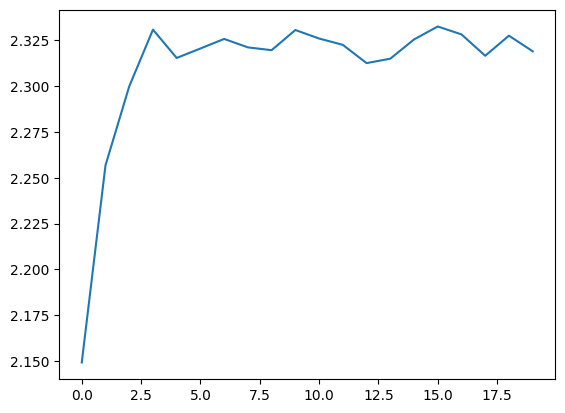

In [13]:
plt.plot(loss_epoch_arr)
plt.show()

In [14]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

0.391 0.3771


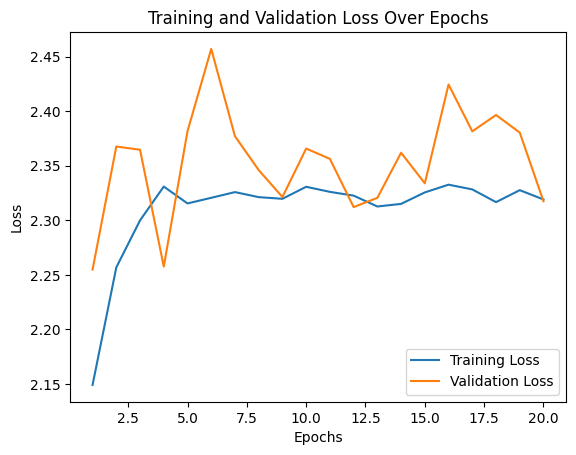

In [15]:
# Plot loss curves
plt.plot(range(1, max_epochs+1), train_loss_arr, label='Training Loss')
plt.plot(range(1, max_epochs+1), val_loss_arr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()